# Face Mesh Model

จากโมเดลที่พัฒนาโดย Mediapipe ทำให้เราสามารถแสดงโครงใบหน้าได้ โดยอาศัยการเรียนรู้ภาพต้นแบบสามมิติ นำมาหาค่าพิกัดที่สำคัญ เพื่อใช้แสดงผลเป็นรูปทรงเรขาคณิตของใบหน้าจำนวน 468 พิกัด ดังรูป <br><br>

![face_mesh_architecture.png](https://mediapipe.dev/images/attention_mesh_architecture.png)<br><br>

ในการวัดมุมของใบหน้าจะถูกแบ่งเป็น 5 ทิศทาง ได้แก่ หน้าตรง, ก้มหน้า, เงยหน้า, หันซ้าย, และหันขวา

1. **ก้มหน้า / เงยหน้า** ทำการวัดระยะทางระหว่างริมฝีปากด้านบนกับจุดระหว่างคิ้ว (ตำแหน่งที่ 0 กับ 8) เปรียบเทียบกับระยะทางระหว่างริมฝีปากด้านบนกับปลายจมูก (ตำแหน่งที่ 0 กับ 4) โดยวัดในระนาบเดียวกัน (ใช้วิธี projection ด้วย) ในกรณีที่อัตราส่วนระยะทางของคิ้วกับปาก *มากกว่า* ระยะทางของจมูกกับปาก เกินกว่า 3 เท่า (บวก/ลบ 20เปอร์เซ็น) จะถูกนับว่าก้มหน้าลง

2. **หันซ้าย / หันขวา** ทำการวัดระยะทางระหว่างหางตาฝั่งซ้ายถึงดั้งจมูก (ตำแหน่งที่ 261 กับ 6) เปรียบเทียบกับระยะทางระหว่างหางตาฝั่งขวาถึงดั้งจมูก (ตำแหน่งที่ 31 กับ 6) ในกรณีที่อัตราส่วนระยะทางของหางตาซ้ายถึงจมูก *น้อยกว่า* ระยะทางของหางตาขวาถึงจมูก เกินกว่า 1 เท่า (บวก/ลบ 20เปอร์เซ็น) จะถูกนับว่าหันซ้าย

<br>

**ตัวอย่างโค้ด**ด้านล่าง จะเป็นการเขียนโปรแกรมเพื่อใช้งานตัวโมเดลจาก Mediapipe ในการทำนายทิศทางของใบหน้า และแสดงผลเป็นรูปภาพพร้อมจุดพิกัดและเส้นเชื่อมแสดงรูปทรงเรขาคณิตของใบหน้า โดยประกอบด้วย 5 ขั้นตอนดังต่อไปนี้

**ขั้นตอนที่ 1** การเชื่อมต่อ Google Drive เพื่อค้นหารูปภาพตัวอย่างที่เก็บอยู่ใน Drive ของคุณ

In [ ]:
# Connect to your Drive folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Install additional libraries for drawing contours on image's output
import subprocess

def check_and_install_library(library_name):
  try:
    subprocess.check_output(['pip', 'freeze', '|', 'grep', library_name], shell=True)
  except subprocess.CalledProcessError:
    subprocess.call(['pip', 'install', library_name])

check_and_install_library("alphashape")

**ขั้นตอนที่ 2** การนำเข้าโมเดลจาก Mediapipe

In [ ]:
import requests
import os
import tensorflow as tf

# Load the TFLite model and allocate tensors.
# Ref. https://google.github.io/mediapipe/solutions/models.html#face-mesh

# URL of the TFLite model
model_url = "https://storage.googleapis.com/mediapipe-assets/face_landmark.tflite"

# Download the model
if not os.path.exists("face_model.tflite"):
    response = requests.get(model_url)
    open("face_model.tflite", "wb").write(response.content)

# Load the TFLite model
model = tf.lite.Interpreter(model_path="face_model.tflite")
model.allocate_tensors()

# Get input and output tensors.
input_details = model.get_input_details()
output_details = model.get_output_details()

**ขั้นตอนที่ 3** นำเข้าและปรับขนาดของภาพให้สอดคล้องกับข้อกำหนดของโมเดล

In [ ]:
import numpy as np
import cv2

# Path of the input image
image_path = "/content/gdrive/MyDrive/Colab Notebooks/AIThaiGen/datasets/faces/010105.jpg"

# Load the image to predict
img = cv2.imread(image_path) # read image from path
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert an image to RGB color space
img = cv2.resize(img, (input_details[0]['shape'][1], input_details[0]['shape'][2])) # resize to match inputs of model
img = img / 255.0 # normalize image data
img = img.astype(np.float32)

**ขั้นตอนที่ 4** ประมวลผลรูปผ่านโมเดลเพื่อทำนายจุดพิกัดสำคัญของใบหน้า

In [ ]:
# Pass the image and Run the model on the image
model.set_tensor(input_details[0]['index'], [img])
model.invoke()

# Get keypoints from the output
keypoints = model.get_tensor(output_details[0]['index'])
keypoints = np.squeeze(keypoints) # remove single-dimensional entries
keypoints = keypoints.reshape(-1, 3)[:, :-1] # reshape to (21, 2) only retrieve 'x' and 'y' axis

**ขั้นตอนที่ 5** แสดงผลรูปการทำนายใบหน้าพร้อมกับทิศทางของใบหน้า

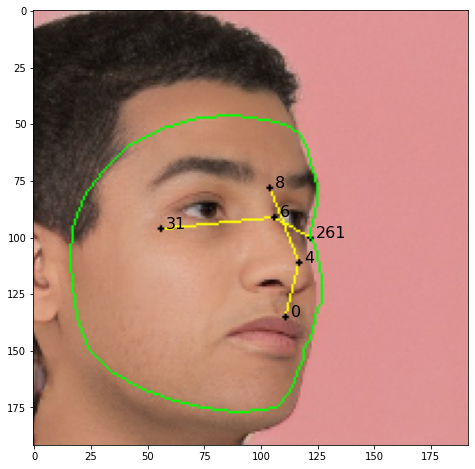

Direction of Face: Straight-Left


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import alphashape

def find_contours(keypoints, alpha=0.1):
    shape = alphashape.alphashape(keypoints, alpha).exterior.coords.xy
    contours = np.column_stack(shape)
    return contours

def calculate_projected_distance(a, b, c):
    ab = b - a
    ac = c - a
    projection = np.dot(ac, ab) / np.dot(ab, ab) * ab + a
    distance = np.linalg.norm(a - projection)
    return distance

# Show the output image
if img[0,0,0] < 1:
    img = (img * 255).astype(np.uint8) # convert image back to [0..255] format
fig, ax = plt.subplots(figsize=(8, 8)) # define size of figure
plt.imshow(img) # display image in the figure

# Draw lines between keypoints
keypoints_pairs = [(0, 4), (4, 8), (6, 31), (6, 261)]
for pair in keypoints_pairs: # loop each key pair to draw line
    x1, y1 = int(keypoints[pair[0],0]), int(keypoints[pair[0],1])
    x2, y2 = int(keypoints[pair[1],0]), int(keypoints[pair[1],1])
    cv2.line(img, (x1, y1), (x2, y2), (255, 255, 0), 1) # draw a line

# # Draw keypoints on the image
for i in [0,4,8,6,31,261]:
    kp = (int(keypoints[i,0]), int(keypoints[i,1]))
    cv2.circle(img, kp, 1, (0, 0, 0), -1)

# Draw face contours on the image
keypoints_contours = find_contours(keypoints)
cv2.drawContours(img, [keypoints_contours.astype(np.int32)], 0, (0, 255, 0), 1)

# Add text overlay on the image
for i in [0,4,8,6,31,261]:
    kp = (int(keypoints[i,0]), int(keypoints[i,1]))
    ax.annotate(i, kp, fontsize=16, xytext=(5,0), textcoords='offset points') # write text of keypoint ID

# Display the output image using matplotlib
plt.imshow(img)
plt.show()

# Face Direction Prediction
# Define the indices for keypoints for 4 positions: mouth, nose, eyebrows, eyes

# -- Check if face is up or down
#    by calculate ratio in distance between mouth-to-nose and mouth-to-eyebrows
mouth = 0
nose = 4
eyebrows = 8
up_distance = np.linalg.norm(keypoints[eyebrows] - keypoints[mouth])
down_distance = calculate_projected_distance(keypoints[mouth], keypoints[eyebrows], keypoints[nose])
ud_ratio = up_distance / down_distance

# -- Check if face is left or right
#    by calculate ratio in distance between eye_left-to-eyes and eye_right-to-eyes
eyes = 6
eye_left = 261
eye_right = 31
left_distance = np.linalg.norm(keypoints[eye_left] - keypoints[eyes])
right_distance = np.linalg.norm(keypoints[eye_right] - keypoints[eyes])
lr_ratio = left_distance / right_distance

# Use criteria to identify the direction of face
#      Up / Down >> the ratio of 3 with +/- 20% ( 2.4, 3.6 )
#      Left / Right >> the ratio of 1 with +/- 20% ( 0.8, 1.2 )
ud_criteria = np.multiply(1 + np.multiply([-1,1],0.2),3)
lr_criteria = np.multiply(1 + np.multiply([-1,1],0.2),1)
ud_text = "Up" if ud_ratio < ud_criteria[0] else "Down" if ud_ratio > ud_criteria[1] else "Straight"
lr_text = "Left" if lr_ratio < lr_criteria[0] else "Right" if lr_ratio > lr_criteria[1] else "Straight"

# Summarize text
if (ud_text == "Straight") and (lr_text == "Straight"):
  text = "Straight"
else:
  text =  ud_text + "-" + lr_text

# Print the output
print("Direction of Face:", text)